In [366]:
from __future__ import division 
from pyomo.environ import * 
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [367]:
m = AbstractModel('TFG_MMP_v1.0_February_2023')

In [368]:
m.G = Set()
m.p = Set()
m.s = Set() 
m.n = Set()
m.t = Set()
m.h = Set()
m.hf = Set()

In [369]:
data = DataPortal()
data.load(filename= 'g.csv', set= m.G)
data.load(filename= 'p.csv', set= m.p)
data.load(filename= 's.csv', set= m.s)
data.load(filename= 'n.csv', set= m.n)
data.load(filename= 't.csv', set= m.t)
data.load(filename= 'h.csv', set= m.h)
data.load(filename= 'hf.csv', set= m.hf)

In [370]:
m.e = 480

In [371]:

m.CO2rate = Param(m.G, within = NonNegativeReals)
m.alfa = Param(m.G, within = NonNegativeReals)
m.beta = Param(m.G, within = NonNegativeReals)
m.gamma = Param(m.G, within = NonNegativeReals)
m.f = Param(m.G, within = NonNegativeReals)
m.o = Param(m.G, within = NonNegativeReals)
m.qmax = Param(m.G, within = NonNegativeReals)
m.qmin = Param(m.G, within = NonNegativeReals)
m.bmax = Param(m.G, within = NonNegativeReals)
m.wmax = Param(m.G)
m.w0 = Param(m.G)
m.wmin = Param(m.G)
m.k = Param(m.G)
m.rend = Param(m.G)

# Read CSV file into pandas DataFrame and convert to Pyomo parameter
param_data = pd.read_csv('Data_duration_demand1.csv', header=0, index_col=[0, 1, 2])
m.a = Param(m.n, m.s, m.p, initialize=param_data['a'].to_dict())
m.d = Param(m.n, m.s, m.p, initialize=param_data['d'].to_dict())

param_data2 = pd.read_csv('Data_inflows1.csv', header=0, index_col=[0, 1])
m.i = Param(m.h, m.p, initialize=param_data2['i'].to_dict())


param_data3 = pd.read_csv('Data_qred1.csv', header=0, index_col=[0, 1, 2, 3])
m.qred = Param(m.t, m.n, m.s, m.p, initialize=param_data3['qred'].to_dict())

data.load(filename="Data_generators1.csv", param=(m.CO2rate, m.alfa , m.beta , m.gamma , m.f , m.o , m.qmax , m.qmin , m.bmax , m.wmax , m.w0 , m.wmin , m.k , m.rend))
#instance = m.create_instance(data)
#instance.pprint()

In [372]:
m.u = Var(m.t, m.n, m.s, m.p,within= Binary) #u(t,s,p) Decision to connect generator g
m.y = Var(m.t,m.s, m.p, within= Binary)#y(t,s,p) Start up decision for generator g
#m.z = Var(m.G, within= Binary)#z(p,s,g) Shut down decision for generator g #IT IS NOT USED IN THE MODEL

In [373]:
m.qt = Var(m.t, m.n, m.s, m.p) #q(t,n,s,p) Net power delivered by thermal generator t [GW]
m.qh = Var(m.h, m.n, m.s, m.p, within= Reals) #q(h,n,s,p) Net power delivered by hydraulic generator h [GW]
m.b = Var(m.h, m.n, m.s, m.p) #b(h,n,s,p)Gross power consumed by pumping-storage plant [GW]
m.w = Var(m.h, m.p) #w(h,p) Hydroelectric energy in the reservoir of the plant [GWh]

In [374]:
def obj_rule (m):
    return sum((m.f[t]*(m.gamma[t]*m.y[t,s,p] + sum((m.a[n, s, p] * (m.alfa[t] * m.qt[t,n,s,p] / m.k [t] + m.beta[t] * m.u[t, n, s, p])) for n in m.n))  + 
        sum((m.a [n, s, p]* m.o[t] * m.qt[t, n, s, p] / m.k[t]) for n in m.n )) for t in m.t for p in m.p for s in m.s)

m.obj = Objective(rule= obj_rule, sense= minimize)

In [375]:

#DECLARATION OF CONSTRAINTS (meaning of warnings????) ## Very important the order
    #Demand balance and marginal cost
def Demand_Bal_rule(m,n,s,p): 
    return sum((m.qt[t,n,s,p]) for t in m.t) + sum((m.qh[h,n,s,p] - m.b[h,n,s,p]) for h in m.h) == m.d[n,s,p]

m.Demand_Bal = Constraint(m.n, m.s, m.p, rule= Demand_Bal_rule)

    #Upper thermal limit 
def Upper_Thermal_rule(m,t,n,s,p):
    return m.qt[t,n,s,p] <= m.u[t,n,s,p] * m.k[t] * m.qmax[t]

m.Upper_Thermal = Constraint(m.t, m.n, m.s, m.p, rule= Upper_Thermal_rule)
    #Upper hydro constraints
def Upper_Hydro_rule(m,h,n,s,p):
    return m.qh[h,n,s,p] <= m.k[h] * m.qmax[h]

m.Upper_Hydro = Constraint(m.h, m.n, m.s, m.p, rule= Upper_Hydro_rule)
    #Maximum Capacity limits for pumped storage
def Cap_Hydro_rule(m,h,n,s,p):
    return m.b[h,n,s,p] <= m.k[h] * m.bmax[h]

m.Cap_Hydro = Constraint(m.h, m.n, m.s, m.p, rule= Cap_Hydro_rule)
    #Lower thermal limit
def Lower_Thermal_rule(m,t,n,s,p):
    return m.qt[t,n,s,p] >= m.u[t,n,s,p] * m.k[t] * m.qmin[t]

m.Lower_Thermal = Constraint(m.t, m.n, m.s, m.p, rule= Lower_Thermal_rule)
    #Energy balance in an equivalent reservoir
def E_Bal_rule(m,h,p):
    if p == m.p.first():
        return Constraint.Skip
    else:
        return m.w[h,p] + sum(m.a[n,s,p] * (m.qh[h,n,s,p] - m.rend[h] * m.b[h,n,s,p]) for n in m.n for s in m.s) <= m.w[h,int(p) - 1] + m.i[h,p]

m.E_Bal = Constraint(m.h, m.p, rule= E_Bal_rule)
    #Upper limit equivalent energy stored in reservoir
def Upper_W_rule(m,h,p):
    return m.w[h,p] <= m.wmax[h]

m.Upper_W = Constraint(m.h, m.p, rule = Upper_W_rule)
    #Lower limit equivalent energy stored in basin
def Lower_W_rule(m,h,p):
    return m.w[h,p] >= m.wmin[h]

m.Lower_W = Constraint(m.h, m.p, rule = Lower_W_rule)
    #Minimum operating hours during the year
def Min_H_rule(m,t):
    return sum((m.a[n,s,p] * m.qt[t,n,s,p]) for n in m.n for s in m.s for p in m.p) >= m.k[t] * m.qmax[t] * m.e

m.Min_H = Constraint(m.t, rule = Min_H_rule)
    #Minimum production to accommodate grid constraints
def Min_Grid_rule(m,t,n,s,p):
    return m.qt[t,n,s,p] >= m.qred[t,n,s,p]

m.Min_Grid = Constraint(m.t, m.n, m.s, m.p, rule = Min_Grid_rule)


In [376]:
m.dual = Suffix(direction=Suffix.IMPORT)

In [377]:
workPath = os.getcwd()

In [378]:
print(data['G'],'\n')
print(data['p'],'\n')
print(data['s'],'\n')
print(data['n'],'\n')
print(data['t'],'\n')
print(data['h'],'\n')
print(data['hf'],'\n')
print(type(data['p'][10]))

['GEN_001', 'GEN_002', 'GEN_003', 'GEN_004', 'GEN_005', 'GEN_006', 'GEN_007', 'GEN_008', 'HYDRO_RES', 'HYDRO_ROR', 'HYDRO_PUM'] 

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12] 

['lab', 'fes'] 

['n1', 'n2', 'n3', 'n4', 'n5'] 

['GEN_001', 'GEN_002', 'GEN_003', 'GEN_004', 'GEN_005', 'GEN_006', 'GEN_007', 'GEN_008'] 

['HYDRO_RES', 'HYDRO_ROR', 'HYDRO_PUM'] 

['HYDRO_PUM'] 

<class 'int'>


In [379]:
instance = m.create_instance(data)
#instance.pprint()

In [380]:
solver = SolverFactory('gurobi')
results = solver.solve(instance)
instance.pprint() #PYOMO WORKS IN ALPHABETICAL ORDER

26 Set Declarations
    Cap_Hydro_index : Size=1, Index=None, Ordered=True
        Key  : Dimen : Domain  : Size : Members
        None :     4 : h*n*s*p :  360 : {('HYDRO_RES', 'n1', 'lab', 1), ('HYDRO_RES', 'n1', 'lab', 2), ('HYDRO_RES', 'n1', 'lab', 3), ('HYDRO_RES', 'n1', 'lab', 4), ('HYDRO_RES', 'n1', 'lab', 5), ('HYDRO_RES', 'n1', 'lab', 6), ('HYDRO_RES', 'n1', 'lab', 7), ('HYDRO_RES', 'n1', 'lab', 8), ('HYDRO_RES', 'n1', 'lab', 9), ('HYDRO_RES', 'n1', 'lab', 10), ('HYDRO_RES', 'n1', 'lab', 11), ('HYDRO_RES', 'n1', 'lab', 12), ('HYDRO_RES', 'n1', 'fes', 1), ('HYDRO_RES', 'n1', 'fes', 2), ('HYDRO_RES', 'n1', 'fes', 3), ('HYDRO_RES', 'n1', 'fes', 4), ('HYDRO_RES', 'n1', 'fes', 5), ('HYDRO_RES', 'n1', 'fes', 6), ('HYDRO_RES', 'n1', 'fes', 7), ('HYDRO_RES', 'n1', 'fes', 8), ('HYDRO_RES', 'n1', 'fes', 9), ('HYDRO_RES', 'n1', 'fes', 10), ('HYDRO_RES', 'n1', 'fes', 11), ('HYDRO_RES', 'n1', 'fes', 12), ('HYDRO_RES', 'n2', 'lab', 1), ('HYDRO_RES', 'n2', 'lab', 2), ('HYDRO_RES', 'n2', 'lab

         ('GEN_005', 'n1', 'lab', 3) :   0.0
         ('GEN_005', 'n1', 'lab', 4) :   0.0
         ('GEN_005', 'n1', 'lab', 5) :   0.0
         ('GEN_005', 'n1', 'lab', 6) :   0.0
         ('GEN_005', 'n1', 'lab', 7) :   0.0
         ('GEN_005', 'n1', 'lab', 8) :   0.0
         ('GEN_005', 'n1', 'lab', 9) :   0.0
        ('GEN_005', 'n1', 'lab', 10) :   0.0
        ('GEN_005', 'n1', 'lab', 11) :   0.0
        ('GEN_005', 'n1', 'lab', 12) :   0.0
         ('GEN_005', 'n2', 'fes', 1) :   0.0
         ('GEN_005', 'n2', 'fes', 2) :   0.0
         ('GEN_005', 'n2', 'fes', 3) :   0.0
         ('GEN_005', 'n2', 'fes', 4) :   0.0
         ('GEN_005', 'n2', 'fes', 5) :   0.0
         ('GEN_005', 'n2', 'fes', 6) :   0.0
         ('GEN_005', 'n2', 'fes', 7) :   0.0
         ('GEN_005', 'n2', 'fes', 8) :   0.0
         ('GEN_005', 'n2', 'fes', 9) :   0.0
        ('GEN_005', 'n2', 'fes', 10) :   0.0
        ('GEN_005', 'n2', 'fes', 11) :   0.0
        ('GEN_005', 'n2', 'fes', 12) :   0.0
         (

        ('HYDRO_PUM', 'n3', 'fes', 10) :  None :                 0.0 :  None : False : False :  Reals
        ('HYDRO_PUM', 'n3', 'fes', 11) :  None :                 0.0 :  None : False : False :  Reals
        ('HYDRO_PUM', 'n3', 'fes', 12) :  None :                 0.0 :  None : False : False :  Reals
         ('HYDRO_PUM', 'n3', 'lab', 1) :  None :                 0.0 :  None : False : False :  Reals
         ('HYDRO_PUM', 'n3', 'lab', 2) :  None :                 0.0 :  None : False : False :  Reals
         ('HYDRO_PUM', 'n3', 'lab', 3) :  None :                 0.0 :  None : False : False :  Reals
         ('HYDRO_PUM', 'n3', 'lab', 4) :  None :                 0.0 :  None : False : False :  Reals
         ('HYDRO_PUM', 'n3', 'lab', 5) :  None :                 0.0 :  None : False : False :  Reals
         ('HYDRO_PUM', 'n3', 'lab', 6) :  None :                 0.0 :  None : False : False :  Reals
         ('HYDRO_PUM', 'n3', 'lab', 7) :  None :                 0.0 :  None : Fal

         ('GEN_007', 'n2', 'lab', 1) :  None :                 0.0 :  None : False : False :  Reals
         ('GEN_007', 'n2', 'lab', 2) :  None :                 0.0 :  None : False : False :  Reals
         ('GEN_007', 'n2', 'lab', 3) :  None :                 0.0 :  None : False : False :  Reals
         ('GEN_007', 'n2', 'lab', 4) :  None :                 0.0 :  None : False : False :  Reals
         ('GEN_007', 'n2', 'lab', 5) :  None :              0.5076 :  None : False : False :  Reals
         ('GEN_007', 'n2', 'lab', 6) :  None :                 0.0 :  None : False : False :  Reals
         ('GEN_007', 'n2', 'lab', 7) :  None :                 0.0 :  None : False : False :  Reals
         ('GEN_007', 'n2', 'lab', 8) :  None :                 0.0 :  None : False : False :  Reals
         ('GEN_007', 'n2', 'lab', 9) :  None :                 0.0 :  None : False : False :  Reals
        ('GEN_007', 'n2', 'lab', 10) :  None :  0.5075999999999998 :  None : False : False :  Reals


        ('GEN_007', 'n3', 'fes', 12) :     0 :  -0.0 :     1 : False : False : Binary
         ('GEN_007', 'n3', 'lab', 1) :     0 :  -0.0 :     1 : False : False : Binary
         ('GEN_007', 'n3', 'lab', 2) :     0 :  -0.0 :     1 : False : False : Binary
         ('GEN_007', 'n3', 'lab', 3) :     0 :  -0.0 :     1 : False : False : Binary
         ('GEN_007', 'n3', 'lab', 4) :     0 :  -0.0 :     1 : False : False : Binary
         ('GEN_007', 'n3', 'lab', 5) :     0 :  -0.0 :     1 : False : False : Binary
         ('GEN_007', 'n3', 'lab', 6) :     0 :  -0.0 :     1 : False : False : Binary
         ('GEN_007', 'n3', 'lab', 7) :     0 :  -0.0 :     1 : False : False : Binary
         ('GEN_007', 'n3', 'lab', 8) :     0 :  -0.0 :     1 : False : False : Binary
         ('GEN_007', 'n3', 'lab', 9) :     0 :  -0.0 :     1 : False : False : Binary
        ('GEN_007', 'n3', 'lab', 10) :     0 :  -0.0 :     1 : False : False : Binary
        ('GEN_007', 'n3', 'lab', 11) :     0 :  -0.0 :

         ('HYDRO_ROR', 'n5', 'fes', 1) :  -Inf :  b[HYDRO_ROR,n5,fes,1] :   0.0 :   True
         ('HYDRO_ROR', 'n5', 'fes', 2) :  -Inf :  b[HYDRO_ROR,n5,fes,2] :   0.0 :   True
         ('HYDRO_ROR', 'n5', 'fes', 3) :  -Inf :  b[HYDRO_ROR,n5,fes,3] :   0.0 :   True
         ('HYDRO_ROR', 'n5', 'fes', 4) :  -Inf :  b[HYDRO_ROR,n5,fes,4] :   0.0 :   True
         ('HYDRO_ROR', 'n5', 'fes', 5) :  -Inf :  b[HYDRO_ROR,n5,fes,5] :   0.0 :   True
         ('HYDRO_ROR', 'n5', 'fes', 6) :  -Inf :  b[HYDRO_ROR,n5,fes,6] :   0.0 :   True
         ('HYDRO_ROR', 'n5', 'fes', 7) :  -Inf :  b[HYDRO_ROR,n5,fes,7] :   0.0 :   True
         ('HYDRO_ROR', 'n5', 'fes', 8) :  -Inf :  b[HYDRO_ROR,n5,fes,8] :   0.0 :   True
         ('HYDRO_ROR', 'n5', 'fes', 9) :  -Inf :  b[HYDRO_ROR,n5,fes,9] :   0.0 :   True
        ('HYDRO_ROR', 'n5', 'fes', 10) :  -Inf : b[HYDRO_ROR,n5,fes,10] :   0.0 :   True
        ('HYDRO_ROR', 'n5', 'fes', 11) :  -Inf : b[HYDRO_ROR,n5,fes,11] :   0.0 :   True
        ('HYDRO_ROR',

         ('GEN_005', 'n3', 'lab', 1) :  -Inf :   0.19949999999999998*u[GEN_005,n3,lab,1] - qt[GEN_005,n3,lab,1] :   0.0 :   True
         ('GEN_005', 'n3', 'lab', 2) :  -Inf :   0.19949999999999998*u[GEN_005,n3,lab,2] - qt[GEN_005,n3,lab,2] :   0.0 :   True
         ('GEN_005', 'n3', 'lab', 3) :  -Inf :   0.19949999999999998*u[GEN_005,n3,lab,3] - qt[GEN_005,n3,lab,3] :   0.0 :   True
         ('GEN_005', 'n3', 'lab', 4) :  -Inf :   0.19949999999999998*u[GEN_005,n3,lab,4] - qt[GEN_005,n3,lab,4] :   0.0 :   True
         ('GEN_005', 'n3', 'lab', 5) :  -Inf :   0.19949999999999998*u[GEN_005,n3,lab,5] - qt[GEN_005,n3,lab,5] :   0.0 :   True
         ('GEN_005', 'n3', 'lab', 6) :  -Inf :   0.19949999999999998*u[GEN_005,n3,lab,6] - qt[GEN_005,n3,lab,6] :   0.0 :   True
         ('GEN_005', 'n3', 'lab', 7) :  -Inf :   0.19949999999999998*u[GEN_005,n3,lab,7] - qt[GEN_005,n3,lab,7] :   0.0 :   True
         ('GEN_005', 'n3', 'lab', 8) :  -Inf :   0.19949999999999998*u[GEN_005,n3,lab,8] - qt[GEN

         ('GEN_004', 'n1', 'lab', 3) :   0.0 :  qt[GEN_004,n1,lab,3] :  +Inf :   True
         ('GEN_004', 'n1', 'lab', 4) :   0.0 :  qt[GEN_004,n1,lab,4] :  +Inf :   True
         ('GEN_004', 'n1', 'lab', 5) :   0.0 :  qt[GEN_004,n1,lab,5] :  +Inf :   True
         ('GEN_004', 'n1', 'lab', 6) :   0.0 :  qt[GEN_004,n1,lab,6] :  +Inf :   True
         ('GEN_004', 'n1', 'lab', 7) :   0.0 :  qt[GEN_004,n1,lab,7] :  +Inf :   True
         ('GEN_004', 'n1', 'lab', 8) :   0.0 :  qt[GEN_004,n1,lab,8] :  +Inf :   True
         ('GEN_004', 'n1', 'lab', 9) :   0.0 :  qt[GEN_004,n1,lab,9] :  +Inf :   True
        ('GEN_004', 'n1', 'lab', 10) :   0.0 : qt[GEN_004,n1,lab,10] :  +Inf :   True
        ('GEN_004', 'n1', 'lab', 11) :   0.0 : qt[GEN_004,n1,lab,11] :  +Inf :   True
        ('GEN_004', 'n1', 'lab', 12) :   0.0 : qt[GEN_004,n1,lab,12] :  +Inf :   True
         ('GEN_004', 'n2', 'fes', 1) :   0.0 :  qt[GEN_004,n2,fes,1] :  +Inf :   True
         ('GEN_004', 'n2', 'fes', 2) :   0.0 :  qt[GEN

        ('HYDRO_RES', 'n2', 'lab', 11) :  -Inf : qh[HYDRO_RES,n2,lab,11] :   1.5 :   True
        ('HYDRO_RES', 'n2', 'lab', 12) :  -Inf : qh[HYDRO_RES,n2,lab,12] :   1.5 :   True
         ('HYDRO_RES', 'n3', 'fes', 1) :  -Inf :  qh[HYDRO_RES,n3,fes,1] :   1.5 :   True
         ('HYDRO_RES', 'n3', 'fes', 2) :  -Inf :  qh[HYDRO_RES,n3,fes,2] :   1.5 :   True
         ('HYDRO_RES', 'n3', 'fes', 3) :  -Inf :  qh[HYDRO_RES,n3,fes,3] :   1.5 :   True
         ('HYDRO_RES', 'n3', 'fes', 4) :  -Inf :  qh[HYDRO_RES,n3,fes,4] :   1.5 :   True
         ('HYDRO_RES', 'n3', 'fes', 5) :  -Inf :  qh[HYDRO_RES,n3,fes,5] :   1.5 :   True
         ('HYDRO_RES', 'n3', 'fes', 6) :  -Inf :  qh[HYDRO_RES,n3,fes,6] :   1.5 :   True
         ('HYDRO_RES', 'n3', 'fes', 7) :  -Inf :  qh[HYDRO_RES,n3,fes,7] :   1.5 :   True
         ('HYDRO_RES', 'n3', 'fes', 8) :  -Inf :  qh[HYDRO_RES,n3,fes,8] :   1.5 :   True
         ('HYDRO_RES', 'n3', 'fes', 9) :  -Inf :  qh[HYDRO_RES,n3,fes,9] :   1.5 :   True
        ('

         ('GEN_006', 'n5', 'lab', 4) :  -Inf :                 qt[GEN_006,n5,lab,4] - 0.392*u[GEN_006,n5,lab,4] :   0.0 :   True
         ('GEN_006', 'n5', 'lab', 5) :  -Inf :                 qt[GEN_006,n5,lab,5] - 0.392*u[GEN_006,n5,lab,5] :   0.0 :   True
         ('GEN_006', 'n5', 'lab', 6) :  -Inf :                 qt[GEN_006,n5,lab,6] - 0.392*u[GEN_006,n5,lab,6] :   0.0 :   True
         ('GEN_006', 'n5', 'lab', 7) :  -Inf :                 qt[GEN_006,n5,lab,7] - 0.392*u[GEN_006,n5,lab,7] :   0.0 :   True
         ('GEN_006', 'n5', 'lab', 8) :  -Inf :                 qt[GEN_006,n5,lab,8] - 0.392*u[GEN_006,n5,lab,8] :   0.0 :   True
         ('GEN_006', 'n5', 'lab', 9) :  -Inf :                 qt[GEN_006,n5,lab,9] - 0.392*u[GEN_006,n5,lab,9] :   0.0 :   True
        ('GEN_006', 'n5', 'lab', 10) :  -Inf :               qt[GEN_006,n5,lab,10] - 0.392*u[GEN_006,n5,lab,10] :   0.0 :   True
        ('GEN_006', 'n5', 'lab', 11) :  -Inf :               qt[GEN_006,n5,lab,11] - 0.392*u[GEN_

In [381]:
results.write()

# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: x2869
  Lower bound: 44658.24
  Upper bound: 44658.24
  Number of objectives: 1
  Number of constraints: 3834
  Number of variables: 2845
  Number of binary variables: 1128
  Number of integer variables: 1128
  Number of continuous variables: 1717
  Number of nonzeros: 8578
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Return code: 0
  Message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Termination condition: optimal
  Termination message: Model was solve

In [382]:
if (results.solver.status == SolverStatus.ok) and (results.solver.termination_condition == TerminationCondition.optimal):
    print('feasible')
    instance.write('MMP.lp')
elif (results.solver.termination_condition == TerminationCondition.infeasible):
    print('infeasible')
else:
    print ('Solver Status:',  result.solver.status)

feasible


In [383]:
print('OBJ=',round(value(instance.obj),2))

OBJ= 44658.24


In [384]:
#dual variables
#Marginal cost of sistem h at level n in subperiod s of period p
for h in instance.h:
    for p in instance.p:
        print(instance.dual[instance.Lower_W[h,p]])

KeyError: "Component with id '2220998516064': Lower_W[HYDRO_RES,1]"

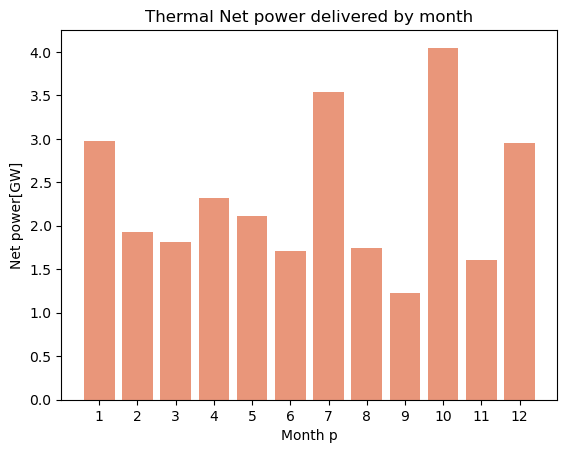

In [345]:

fig, ax = plt.subplots()
x_values = range(1, len(instance.p) + 1)
for p in instance.p:
    [ax.bar(p, value(sum(instance.qt[t, n, s, p] for s in instance.s for n in instance.n for t in instance.t)), color = 'darksalmon')]
ax.set_xticks(x_values)
ax.set_xlabel("Month p")
ax.set_ylabel("Net power[GW]")
ax.set_title("Thermal Net power delivered by month")
plt.show()

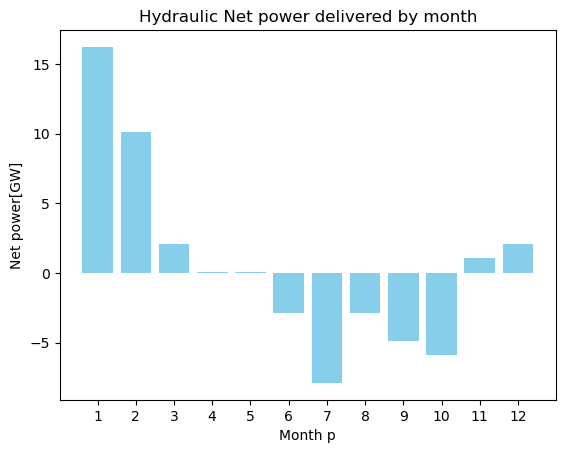

In [328]:
fig2, ax2 = plt.subplots()
x_values = range(1, len(instance.p) + 1)
for p in instance.p:
    [ax2.bar(p, value(sum(instance.qh[h, n, s, p] for s in instance.s for n in instance.n for h in instance.h)), color = 'skyblue')]
ax2.set_xticks(x_values)
ax2.set_xlabel("Month p")
ax2.set_ylabel("Net power[GW]")
ax2.set_title("Hydraulic Net power delivered by month")
plt.show()

**STARTING WITH MATPLOTLIB:**

When we call plt.subplot() function we unpack a tuple with 2 values:

    - Figure: You can reshape it, but not draw on it
    - Axes: The coordinate system (i.e the canvas you draw on)

For more info check out : https://towardsdatascience.com/clearing-the-confusion-once-and-for-all-fig-ax-plt-subplots-b122bb7783ca

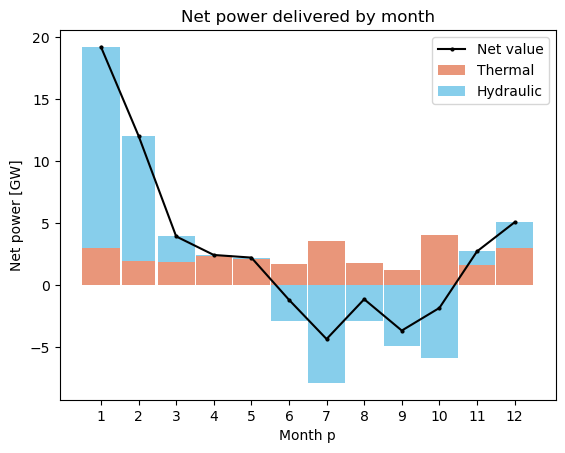

In [330]:
#month_dict =('January', 'February','March','April','May','June','July','August','September'
                #'October', 'November', 'December')

values1 = []
values2 = []
awidth = []
fig3,ax3 = plt.subplots()
x_values = range(1, len(instance.p) + 1)
for p in instance.p:
    values1.append(value(sum(instance.qt[t, n, s, p] for s in instance.s for n in instance.n for t in instance.t)))
    values2.append(value(sum(instance.qh[h, n, s, p] for s in instance.s for n in instance.n for h in instance.h)))
    awidth.append(value(sum(instance.a[n, s, p] for s in instance.s for n in instance.n)))
    ax3.bar(p, values1[p - 1], width = awidth[p - 1] / 750,color='darksalmon')
    if values2 [p - 1] >= 0:
        ax3.bar(p, values2[p - 1], bottom = values1[p - 1], width = awidth[p - 1] / 750, color='skyblue')
    else: #Because we have negative values, the bottom needs to be set to zero to avoid overlapping
        ax3.bar(p, values2[p - 1],width = awidth[p - 1] / 750, color = 'skyblue')
    #print("value thermal", p, ":", values1[p - 1])
    #print("value hydraulic", p, ":", values2[p - 1])
    #print("hours of work in month", p,":", awidth[p - 1])

#values3 = []
#values3 = [(values1[p - 1] + values2[p - 1]) for p in instance.p]
plt.plot(instance.p, list(map(lambda p: values1[p - 1] + values2[p - 1], instance.p))
, color = 'black', marker= 'o', markersize= '2')
#print(map(lambda p: values1[p - 1] + values2[p - 1], instance.p))

# Customizing the chart
ax3.set_xticks(x_values)
ax3.set_xlabel("Month p")
ax3.set_ylabel("Net power [GW]")
ax3.set_title("Net power delivered by month")
ax3.legend(['Net value', 'Thermal', 'Hydraulic'])

# Displaying the chart
plt.show()
    

In [331]:
print(instance.s.at(1))

lab


In [332]:
#Create multindex dataframe
arrays = []
aux = []
for i in range(1,len(instance.s) + 1):
    if i == 1:
        aux = [instance.s.at(i) for j in range(1,len(instance.n) + 1)]
        arrays.append(aux)
    else:
        aux = [instance.s.at(i) for j in range(1,len(instance.n) + 1)]
        arrays[i - 2].extend(aux)
for k in range(1, len(instance.s) + 1):
    aux = [instance.n.at(l) for l in range(1,len(instance.n) + 1)]
    if k == 1:
        arrays.append(aux)
    else: 
        arrays[len(instance.s) - 1].extend(aux)
print(arrays)

[['lab', 'lab', 'lab', 'lab', 'lab', 'fes', 'fes', 'fes', 'fes', 'fes'], ['n1', 'n2', 'n3', 'n4', 'n5', 'n1', 'n2', 'n3', 'n4', 'n5']]


In [333]:
index = pd.MultiIndex.from_tuples(list(zip(*arrays)))
#print(index)
#print(list(zip(*arrays)))

In [334]:
data_array= [10.0]
#t,h -> n-> s -> p
for s in instance.s:
    for n in instance.n:
        values1 = value(sum(instance.qt[t, n, s, 1] for t in instance.t))
        data_array.append(values1)
        #print("values thermal ",values1, " at level ",n,"in week ",s)
for s in instance.s:
    for n in instance.n:       
        values2 = value(sum(instance.qh[h, n, s, 1] for h in instance.h))
        data_array.append(values2)
        #print("values hydraulic ",values2, " at level ",n,"in week ",s)

        
data_array.remove(10.0)
#print(data_array)
my_array = np.array(data_array)

resized_array = my_array.reshape(2,10)
print(resized_array)

[[1.2122 0.     0.     0.392  0.6827 0.     0.     0.     0.6862 0.    ]
 [1.5878 1.4    2.     2.108  1.3173 2.     1.5    2.1    2.1138 0.1   ]]


      lab                           fes                       
       n1   n2   n3     n4      n5   n1   n2   n3      n4   n5
0  1.2122  0.0  0.0  0.392  0.6827  0.0  0.0  0.0  0.6862  0.0
1  1.5878  1.4  2.0  2.108  1.3173  2.0  1.5  2.1  2.1138  0.1


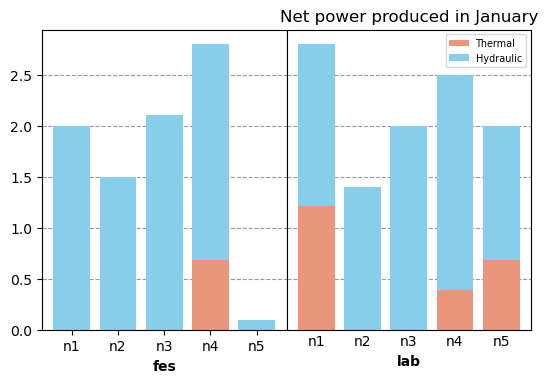

In [335]:
df = pd.DataFrame(data=resized_array ,columns= index)
print(df)
#print(df.columns.levels[0])
#print(df.columns.levels[1])
#Plotting
fig, axes = plt.subplots(nrows=1, ncols=2, sharey= True, figsize= (14 / 2.54, 10 / 2.54))
for i, col in enumerate(df.columns.levels[0]):
    #print(col)
    #print(i)
    ax = axes[i]
    df[col].T.plot(ax=ax, kind='bar',stacked= True, width=.8, color=['darksalmon','skyblue'])
    

    ax.legend_.remove()
    ax.set_xlabel(col, weight='bold')
    ax.yaxis.grid(visible=True, which='major', color='black', linestyle='--', alpha=.4)
    ax.set_axisbelow(True)

    for tick in ax.get_xticklabels():
        tick.set_rotation(0)

#make the ticklines invisible
ax.tick_params(axis=u'both', which=u'both', length=0)
ax.set_title("Net power produced in January")
plt.tight_layout()
# remove spacing in between
fig.subplots_adjust(wspace=0)  # space between plots
ax.legend(['Thermal', 'Hydraulic'], fontsize= 'x-small')
plt.show()

In [336]:
#Create multindex dataframe
arrays = []
aux = []

for p in instance.p:
    if p == 1:
        aux = [instance.p.at(1) for j in range(1, len(instance.p) - 1)]
        arrays.append(aux)
        aux=[]
    else:
        aux = [instance.p.at(p) for j in range(1, len(instance.p) - 1)]
        arrays[0].extend(aux)
for p in instance.p:           
    for i in range(1,len(instance.s) + 1):
        if i == 1 and p == 1:
            aux = [instance.s.at(i) for j in range(1,len(instance.n) + 1)]
            arrays.append(aux)
        else:
            aux = [instance.s.at(i) for j in range(1,len(instance.n) + 1)]
            arrays[1].extend(aux)
for p in instance.p:
    for k in range(1, len(instance.s) + 1):
        aux = [instance.n.at(l) for l in range(1,len(instance.n) + 1)]
        if k == 1 and p == 1:
            arrays.append(aux)
        else: 
            arrays[2].extend(aux)

    
#print(arrays)

In [337]:
index = pd.MultiIndex.from_tuples(list(zip(*arrays)))
#print(index)
#print(list(zip(*arrays)))

In [338]:
data_array= [10.0]
for p in instance.p:
    for s in instance.s:
        for n in instance.n:
            values1 = value(sum(instance.qt[t, n, s, p] for t in instance.t))
            data_array.append(values1)
            #print("values thermal ",values1, " at level ",n,"in week ",s)
for p in instance.p:
    for s in instance.s:
        for n in instance.n:       
            values2 = value(sum(instance.qh[h, n, s, p] for h in instance.h))
            data_array.append(values2)
            #print("values hydraulic ",values2, " at level ",n,"in week ",s)

data_array.remove(10.0)
#print(data_array)
my_array = np.array(data_array)

resized_array = my_array.reshape(2,120)
print(resized_array)

[[  1.2122   0.       0.       0.392    0.6827   0.       0.       0.
    0.6862   0.       0.3572   0.329    0.       0.       0.8852   0.
    0.       0.       0.3572   0.       1.3072   0.       0.       0.
    0.5076   0.       0.       0.       0.       0.       0.3572   0.
    0.       0.329    1.2772   0.       0.       0.       0.3572   0.
    0.8852   0.5076   0.       0.       0.3572   0.       0.       0.
    0.3572   0.       0.3572   0.658    0.       0.       0.6897   0.
    0.       0.       0.       0.       0.8648   0.528    0.95     0.3325
    0.8648   0.       0.       0.       0.       0.       0.8852   0.
    0.       0.       0.8648   0.       0.       0.       0.       0.
    0.3572   0.       0.       0.       0.8648   0.       0.       0.
    0.       0.       0.3572   1.1621   2.1955   0.3325   0.       0.
    0.       0.       0.       0.       1.2772   0.       0.       0.
    0.       0.329    0.       0.       0.       0.       0.3572   0.
    0.       0. 

       1                                                        ...      12  \
      lab                           fes                         ...     lab   
       n1   n2   n3     n4      n5   n1   n2   n3      n4   n5  ...      n1   
0  1.2122  0.0  0.0  0.392  0.6827  0.0  0.0  0.0  0.6862  0.0  ...  0.3572   
1  1.5878  1.4  2.0  2.108  1.3173  2.0  1.5  2.1  2.1138  0.1  ...  2.0000   

                                                         
                              fes                        
    n2   n3   n4      n5       n1   n2   n3     n4   n5  
0  0.0  0.0  0.0  1.1691   0.8996  0.0  0.0  0.528  0.0  
1  2.0  2.0  2.0  1.0000 -13.0000  2.0  2.0  2.000  0.1  

[2 rows x 120 columns]
Int64Index([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12], dtype='int64')
Index(['fes', 'lab'], dtype='object')
Index(['n1', 'n2', 'n3', 'n4', 'n5'], dtype='object')


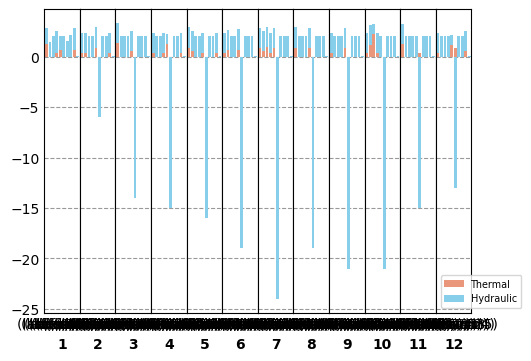

In [341]:
df = pd.DataFrame(data=resized_array ,columns= index)
print(df)
print(df.columns.levels[0])
print(df.columns.levels[1])
print(df.columns.levels[2])
#Plotting
fig, axes = plt.subplots(nrows=1, ncols=12, sharey= True, figsize= (14 / 2.54, 10 / 2.54))
for i, col in enumerate(df.columns.levels[0]):
    #print(col)
    #print(i)
    ax = axes[i]
    df[col].T.plot(ax=ax, kind='bar',stacked= True, width=.8, color=['darksalmon','skyblue'])
    

    ax.legend_.remove()
    ax.set_xlabel(col, weight='bold')
    ax.yaxis.grid(visible=True, which='major', color='black', linestyle='--', alpha=.4)
    ax.set_axisbelow(True)

    for tick in ax.get_xticklabels():
        tick.set_rotation(0)

    #make the ticklines invisible
    ax.tick_params(axis=u'both', which=u'both', length=0)
#ax.set_title("Net power produced in January")
#plt.tight_layout()
# remove spacing in between
fig.subplots_adjust(wspace=0)  # space between plots
ax.legend(['Thermal', 'Hydraulic'], fontsize= 'x-small')
plt.show()